In [63]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [64]:
# Make the original data
series = np.sin((0.1 * np.arange(400)) ** 2)

This is a time series of form:<br>
\begin{align}
x & = \sin(wt^2) \\
\end{align}

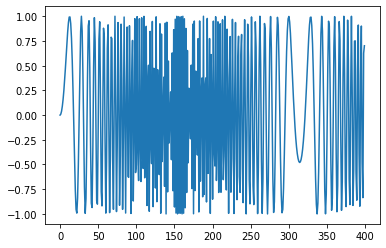

In [65]:
# Plot
plt.plot(series)
plt.show()

In [66]:
### Build the dataset
# Let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series)-T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

In [67]:
X = np.array(X).reshape(-1, T, 1) # Make it N x T
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape",X.shape, "Y.shape", Y.shape)

X.shape (390, 10, 1) Y.shape (390, 1)


In [68]:
### Set Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [69]:
### Define LSTM
class LSTM(nn.Module):
    def __init__(self, n_inputs, n_hiddens, n_rnnlayers, n_outputs):
        super().__init__()
        self.D = n_inputs
        self.M = n_hiddens
        self.K = n_outputs
        self.L = n_rnnlayers
        
        self.lstm = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            batch_first=True
        )
        self.fc = nn.Linear(self.M, self.K)
        
    def forward(self, X):
        # Initial Hidden states and Cell states
        h0 = torch.zeros(self.L, X.shape[0], self.M).to(device)
        c0 = torch.zeros(self.L, X.shape[0], self.M).to(device)
        
        # get LSTM output
        # out is of size (N, T, M)
        out, _ = self.lstm(X,(h0,c0))
        
        # we only use h(t) at the final timestep
        out = self.fc(out[:,-1,:])
        return out

In [70]:
model = LSTM(n_inputs=1, n_hiddens=13, n_rnnlayers=5, n_outputs=1)
model.to(device)

LSTM(
  (lstm): LSTM(1, 13, num_layers=5, batch_first=True)
  (fc): Linear(in_features=13, out_features=1, bias=True)
)

In [71]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [72]:
# Make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [73]:
X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

In [74]:
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=200):
    # Storing losses.
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward Pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Backward Optimization
        loss.backward()
        optimizer.step()
        
        # Save loss
        train_losses[epoch] = loss.item()
        
        # Test loss
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[epoch] = test_loss.item()
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}]. Train loss : {loss.item():.3f}. Test loss : {test_loss.item():.3f}')
            

    return train_losses, test_losses

In [75]:
train_losses, test_losses = full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test)

Epoch [5/200]. Train loss : 0.535. Test loss : 0.467
Epoch [10/200]. Train loss : 0.534. Test loss : 0.468
Epoch [15/200]. Train loss : 0.534. Test loss : 0.467
Epoch [20/200]. Train loss : 0.534. Test loss : 0.467
Epoch [25/200]. Train loss : 0.534. Test loss : 0.468
Epoch [30/200]. Train loss : 0.521. Test loss : 0.492
Epoch [35/200]. Train loss : 0.411. Test loss : 0.624
Epoch [40/200]. Train loss : 0.298. Test loss : 0.480
Epoch [45/200]. Train loss : 0.218. Test loss : 0.456
Epoch [50/200]. Train loss : 0.223. Test loss : 0.386
Epoch [55/200]. Train loss : 0.227. Test loss : 0.424
Epoch [60/200]. Train loss : 0.219. Test loss : 0.476
Epoch [65/200]. Train loss : 0.182. Test loss : 0.343
Epoch [70/200]. Train loss : 0.262. Test loss : 0.391
Epoch [75/200]. Train loss : 0.163. Test loss : 0.302
Epoch [80/200]. Train loss : 0.188. Test loss : 0.318
Epoch [85/200]. Train loss : 0.150. Test loss : 0.287
Epoch [90/200]. Train loss : 0.112. Test loss : 0.225
Epoch [95/200]. Train loss : 

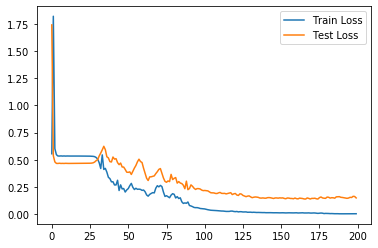

In [76]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()

In [77]:
# "Wrong" forecast using true target
validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = 0

while len(validation_predictions) < len(validation_target):
    input_ = X_test[i].reshape(1, T, 1)
    p = model(input_)[0,0].item()
    i += 1
    
    # Update the prediction list
    validation_predictions.append(p)

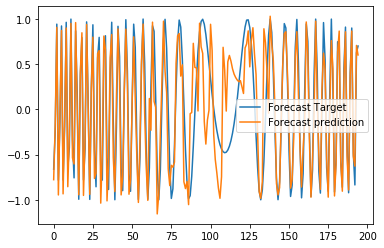

In [78]:
plt.plot(validation_target, label='Forecast Target')
plt.plot(validation_predictions, label='Forecast prediction')
plt.legend()
plt.show()

In [79]:
validation_target = Y[-N//2:]
validation_predictions = []

last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
    input_ = last_x.reshape(1,T,1)
    p = model(input_)
    # [0, 0]. 1 x 1 array -> scalar
    
    # Update the prediction list
    validation_predictions.append(p[0,0].item())
    
    last_x = torch.cat((last_x[1:], p[0]))

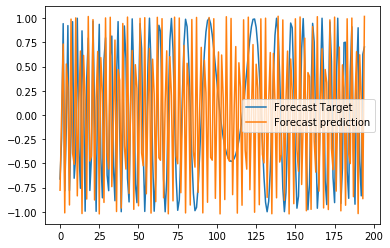

In [80]:
plt.plot(validation_target, label='Forecast Target')
plt.plot(validation_predictions, label='Forecast prediction')
plt.legend()
plt.show()